In [1]:
from pipeline_creation import create_pipeline, make_list_of_elements, get_file_paths, weights_to_apply, equalize_histogram
from utils import threshold_array, get_random_indices, get_class_weights
from losses import focal_tversky

import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import random
import cv2 
import time
import os
import h5py

import tensorflow as tf 
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, add, multiply, Lambda
from keras.layers import AveragePooling2D, average, UpSampling2D, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.initializers import glorot_normal, random_normal, random_uniform
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras import backend as K
from keras.applications import VGG19, densenet
from keras.models import load_model

from sklearn.metrics import roc_curve, auc, precision_recall_curve # roc curve tools
from sklearn.model_selection import train_test_split

In [2]:
with open('config.json') as f:
    config = json.load(f)

In [3]:
K.set_image_data_format('channels_last')  # Set the data format to 'channels_last' (TensorFlow dimension ordering)
# Define weight initialization method
kinit = 'glorot_normal'

# Utility function to repeat tensor elements
def expend_as(tensor, rep, name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat

# Function to create an Attention Gating Block
def AttnGatingBlock(x, g, inter_shape, name):
    ''' 
    This function takes two inputs, 'x' and 'g', and calculates attention coefficients.
    It performs the following steps:
    1. Convolutions are applied to 'x' and 'g' to match their channel dimensions.
    2. 'g' is upsampled to have the same spatial dimensions as 'x'.
    3. The upsampled 'g' and 'x' are concatenated.
    4. Activation functions (ReLU and sigmoid) are applied to obtain attention coefficients.
    5. The attention coefficients are upsampled to match the original spatial dimensions of 'x'.
    6. Element-wise multiplication is performed between the upsampled attention coefficients and 'x' to obtain the attended feature map.
    '''
    # Get shapes of 'x' and 'g'
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    # Convolution on 'x' to match dimensions
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    # Get shape of the convolved 'theta_x'
    shape_theta_x = K.int_shape(theta_x)

    # Convolution on 'g' to match dimensions
    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    # Upsample 'g' to match 'theta_x' dimensions
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    # Concatenate upsampled 'g' and 'theta_x'
    concat_xg = add([upsample_g, theta_x])

    # Apply ReLU activation
    act_xg = Activation('relu')(concat_xg)
    # Calculate attention coefficients ('psi')
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    # Apply sigmoid activation to obtain attention coefficients
    sigmoid_xg = Activation('sigmoid')(psi)
    # Get shape of sigmoid activation
    shape_sigmoid = K.int_shape(sigmoid_xg)
     # Upsample attention coefficients to match original spatial dimensions of 'x'
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    # Expand attention coefficients to match the number of channels in 'x'
    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    # Multiply attention coefficients and 'x' to obtain attended feature map
    y = multiply([upsample_psi, x], name='q_attn'+name)

    # Convolution on the attended feature map
    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    # Batch normalization on the result
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

# Function to define a U-Net convolution block
def UnetConv2D(input, outdim, is_batchnorm, name):
    '''
    This function defines a U-Net convolution block.
    It performs two convolution operations, each followed by batch normalization and ReLU activation.
    '''
	
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
    if is_batchnorm:
        x =- BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu',name=name + '_1_act')(x)
    
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x
	
# Function to create a U-Net gating signal
def UnetGatingSignal(input, is_batchnorm, name):
    '''
    This function creates a U-Net gating signal.
    It performs a 1x1 convolution, batch normalization (optional), and ReLU activation.
    '''
    # Get the shape of the input tensor
    shape = K.int_shape(input)
    # 1x1 Convolution:
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        # Batch Normalization (optional):
        x = BatchNormalization(name=name + '_bn')(x)
    # ReLU Activation:
    x = Activation('relu', name = name + '_act')(x)
    return x

#model proposed in my paper - improved attention u-net with multi-scale input pyramid and deep supervision

def attn_reg(input_size):
    
    img_input = Input(shape=input_size, name='input_scale1')
    scale_img_2 = AveragePooling2D(pool_size=(2, 2), name='input_scale2')(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2), name='input_scale3')(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2), name='input_scale4')(scale_img_3)

    conv1 = UnetConv2D(img_input, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    input2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_scale2')(scale_img_2)
    input2 = concatenate([scale_img_2, input2, pool1], axis=3)
    conv2 = UnetConv2D(input2, 64, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    input3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_scale3')(scale_img_3)
    input3 = concatenate([scale_img_3, input3, pool2], axis=3)
    conv3 = UnetConv2D(input3, 128, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    input4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv_scale4')(scale_img_4)
    input4 = concatenate([scale_img_4, input4, pool3], axis=3)
    conv4 = UnetConv2D(input4, 64, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
        
    center = UnetConv2D(pool4, 512, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')

    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')
    
    conv6 = UnetConv2D(up1, 256, is_batchnorm=True, name='conv6')
    conv7 = UnetConv2D(up2, 128, is_batchnorm=True, name='conv7')
    conv8 = UnetConv2D(up3, 64, is_batchnorm=True, name='conv8')
    conv9 = UnetConv2D(up4, 32, is_batchnorm=True, name='conv9')

    out6 = Conv2D(1, (1, 1), activation='sigmoid', name='pred1')(conv6)
    out7 = Conv2D(1, (1, 1), activation='sigmoid', name='pred2')(conv7)
    out8 = Conv2D(1, (1, 1), activation='sigmoid', name='pred3')(conv8)
    out9 = Conv2D(1, (1, 1), activation='sigmoid', name='final')(conv9)

    model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9])

    return model

In [4]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = attn_reg((config['img_size'], config['img_size']) + (3,))

In [5]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_scale1 (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 256, 256, 32)         896       ['input_scale1[0][0]']        
                                                                                                  
 conv1_1_bn (BatchNormaliza  (None, 256, 256, 32)         128       ['conv1_1[0][0]']             
 tion)                                                                                            
                                                                                                  
 tf.math.negative (TFOpLamb  (None, 256, 256, 32)         0         ['conv1_1_bn[0][0]']      

In [6]:
img_row = 256
img_col = 256
img_chan = 3
gt_chan = 1
epochnum = 10
val_split = 0.2
input_size = (img_row, img_col, img_chan)

img_list, gt_list = get_file_paths()

# n = 4000
# random_indices = get_random_indices(range(len(img_list)), n)
# random_indices.sort()
# img_list = np.array(img_list)[random_indices].tolist()
# gt_list = np.array(gt_list)[random_indices].tolist()

num_imgs = len(img_list)

orig_imgs = []
orig_gts = []
imgs = np.zeros((num_imgs, img_row, img_col, 3))
gts = np.zeros((num_imgs, img_row, img_col))


In [7]:
for i in tqdm(range(num_imgs)):
    tmp_img = plt.imread(img_list[i])
    tmp_gt = plt.imread(gt_list[i])
    orig_imgs.append(tmp_img)
    orig_gts.append(tmp_gt)

    img = cv2.resize(tmp_img, (img_col,img_row), interpolation=cv2.INTER_NEAREST)
    gt = cv2.resize(tmp_gt,(img_col,img_row), interpolation=cv2.INTER_NEAREST)

    # img = equalize_histogram(img, convert_to_tensors=False)
    
    if img.max() > 1:
        img = img/255.
    if gt.max() > 1:
        gt = gt/255.
        
    imgs[i] = img
    gts[i] = gt

100%|█████████████████████████████████████████████████████████████████████████████| 6156/6156 [00:19<00:00, 321.41it/s]


In [8]:
imgs[0].shape

(256, 256, 3)

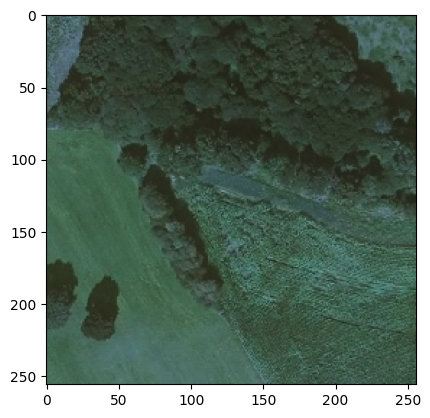

In [9]:
plt.imshow(imgs[1])

In [10]:
indices = np.arange(0,num_imgs,1)

imgs_train, imgs_test, \
imgs_mask_train, imgs_mask_test,\
trainIdx, testIdx = train_test_split(imgs, gts, indices, test_size=0.25)

# imgs_train = np.expand_dims(imgs_train, axis=3)
imgs_mask_train = np.expand_dims(imgs_mask_train,axis=3)
imgs_mask_test = np.expand_dims(imgs_mask_test,axis=3)
# imgs_test = np.expand_dims(imgs_test, axis=3)


In [11]:
imgs_mask_test[0].max()

1.0

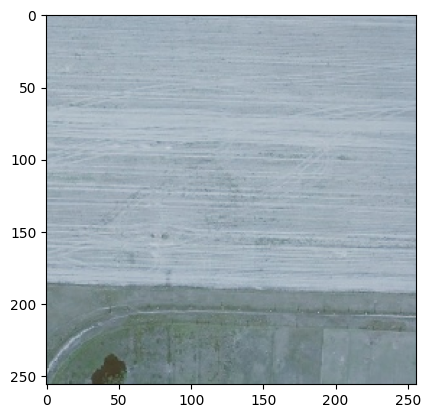

In [12]:
plt.imshow(imgs_test[0])

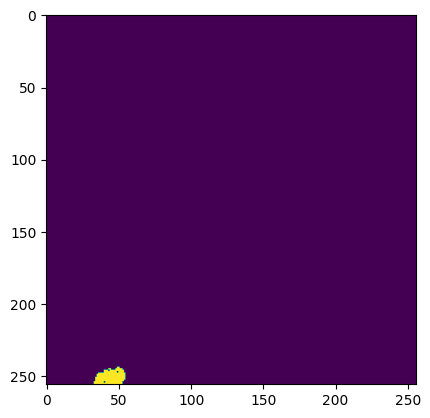

In [13]:
plt.imshow(imgs_mask_test[0])

In [14]:
LR = 1e-3

loss = {'pred1':focal_tversky,
        'pred2':focal_tversky,
        'pred3':focal_tversky,
        'final': focal_tversky}

loss_weights = {'pred1':1,
                'pred2':1,
                'pred3':1,
                'final':1}
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), 
              loss=loss, loss_weights=loss_weights,
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.IoU(num_classes=2, target_class_ids=[1])])

# SGD(lr=0.01, momentum=0.90, decay=1e-6)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=focal_tversky, metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.IoU(num_classes=2, target_class_ids=[1])])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=Combo_loss, metrics=[keras.metrics.BinaryAccuracy()])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.BinaryFocalCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])

callbacks = [
    keras.callbacks.ModelCheckpoint(config['models_dir']+f"intermediary_ImprovedAttentionUnet_{int((1-val_split)*len(imgs_train))}_trains_no_equalizing_with_normalizing_{epochnum}_epochs_img_size_256_LR_{LR}_BS_32_FocalTverskyLoss".replace('.', '_').replace('-','_') + ".h5", save_best_only=True)
]

In [15]:
gt1 = imgs_mask_train[:,::8,::8,:]
gt2 = imgs_mask_train[:,::4,::4,:]
gt3 = imgs_mask_train[:,::2,::2,:]
gt4 = imgs_mask_train
gt_train = [gt1,gt2,gt3,gt4]

In [16]:
len(imgs_train)

4617

In [17]:
hist = model.fit(imgs_train, gt_train, validation_split=val_split,
                 shuffle=True, batch_size=32, epochs=epochnum,
                 verbose=True, callbacks=[callbacks])

Epoch 1/10
116/116 [==============================] - ETA: 0s - loss: 0.3162 - pred1_loss: 0.0719 - pred2_loss: 0.0703 - pred3_loss: 0.0785 - final_loss: 0.0954 - pred1_binary_accuracy: 0.9015 - pred1_io_u: 0.3499 - pred2_binary_accuracy: 0.9013 - pred2_io_u: 0.0669 - pred3_binary_accuracy: 0.9036 - pred3_io_u: 0.0000e+00 - final_binary_accuracy: 0.8940 - final_io_u: 0.0000e+00 

C:\Users\adelabrosse\.conda\envs\inrae_seg_env\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 1845s 16s/step - loss: 0.3162 - pred1_loss: 0.0719 - pred2_loss: 0.0703 - pred3_loss: 0.0785 - final_loss: 0.0954 - pred1_binary_accuracy: 0.9015 - pred1_io_u: 0.3499 - pred2_binary_accuracy: 0.9013 - pred2_io_u: 0.0669 - pred3_binary_accuracy: 0.9036 - pred3_io_u: 0.0000e+00 - final_binary_accuracy: 0.8940 - final_io_u: 0.0000e+00 - val_loss: 3.9127 - val_pred1_loss: 0.9965 - val_pred2_loss: 0.9944 - val_pred3_loss: 0.9778 - val_final_loss: 0.9439 - val_pred1_binary_accuracy: 0.7342 - val_pred1_io_u: 0.0000e+00 - val_pred2_binary_accuracy: 0.7341 - val_pred2_io_u: 0.0000e+00 - val_pred3_binary_accuracy: 0.7341 - val_pred3_io_u: 0.0000e+00 - val_final_binary_accuracy: 0.7340 - val_final_io_u: 0.0000e+00
Epoch 2/10
116/116 [==============================] - 1821s 16s/step - loss: 0.2279 - pred1_loss: 0.0577 - pred2_loss: 0.0548 - pred3_loss: 0.0553 - final_loss: 0.0602 - pred1_binary_accuracy: 0.9159 - pred1_io_u: 0.4064 - pred2_binary_accuracy

In [18]:
model.save((config['models_dir'] + 'ImprovedAttentionUnet_' + str(int((1-val_split)*len(imgs_train))) + '_trains_' + '_epochs-' + str(epochnum) + f'_no_equalizing_with_normalizing_img_size_256_LR_{LR}_BS_32_FocalTverskyoLoss').replace('.', '_').replace('-','_') + '.h5')
# model = keras.models.load_model(model_dir+'Resnet50-U-net_train-65536_seed-1337')
# model = keras.models.load_model('output_models/Resnet50_Unet_4000_train_epochs_5_with_equalizing_with_normalizing_img_size_256_LR_0_0001_BS_64_FocalLoss.h5')

In [19]:
imgs_test.shape

(1539, 256, 256, 3)

In [20]:
gt_test_1 = imgs_mask_test[:,::8,::8,:]
gt_test_2 = imgs_mask_test[:,::4,::4,:]
gt_test_3 = imgs_mask_test[:,::2,::2,:]
gt_test_4 = imgs_mask_test
gt_test = [gt_test_1,gt_test_2,gt_test_3,gt_test_4]

model.evaluate(imgs_test, gt_test)
# val_preds = model.predict(val_ds)

49/49 [==============================] - 165s 3s/step - loss: 0.1160 - pred1_loss: 0.0310 - pred2_loss: 0.0284 - pred3_loss: 0.0282 - final_loss: 0.0284 - pred1_binary_accuracy: 0.9585 - pred1_io_u: 0.1630 - pred2_binary_accuracy: 0.9590 - pred2_io_u: 0.2628 - pred3_binary_accuracy: 0.9587 - pred3_io_u: 2.7067e-04 - final_binary_accuracy: 0.9586 - final_io_u: 0.0000e+00


[0.11601997911930084,
 0.03100740537047386,
 0.028385769575834274,
 0.02821638435125351,
 0.028410427272319794,
 0.9584596157073975,
 0.16304363310337067,
 0.9589610695838928,
 0.2628421187400818,
 0.9586672782897949,
 0.00027067482005804777,
 0.9586327075958252,
 0.0]

In [21]:
val_preds = model.predict(imgs_test)

49/49 [==============================] - 169s 3s/step


In [22]:
val_preds[0][0].shape

(32, 32, 1)

In [61]:
idx = -5

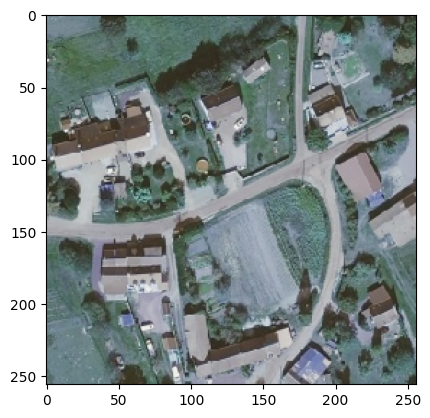

In [62]:
plt.imshow(imgs_test[idx])

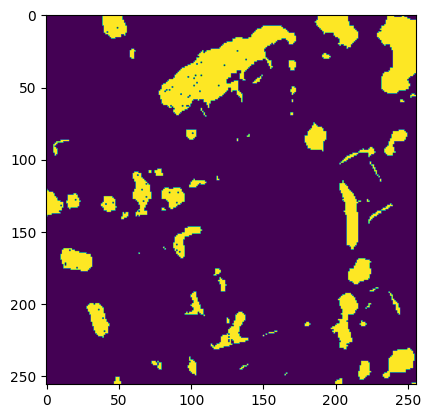

In [63]:
plt.imshow(imgs_mask_test[idx])

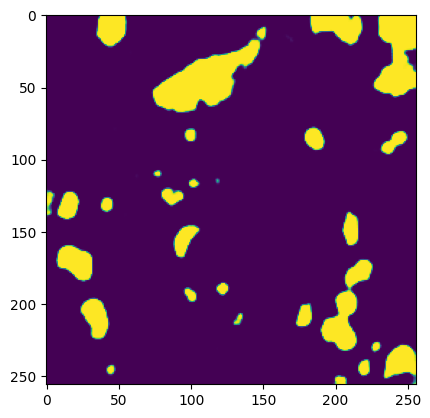

In [64]:
plt.imshow(val_preds[3][idx])

In [65]:
from skimage.transform import resize
predictions = [val_preds[0][idx], val_preds[1][idx], val_preds[2][idx], val_preds[3][idx]]
target_shape = (256, 256, 1)  # Common target shape

# Resize each prediction to the target shape
resized_predictions = [resize(p, target_shape, mode='reflect', preserve_range=True) for p in predictions]
ensemble_prediction = np.mean(resized_predictions, axis=0)

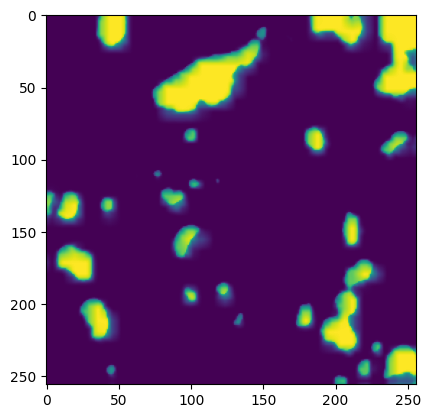

In [66]:
plt.imshow(ensemble_prediction)

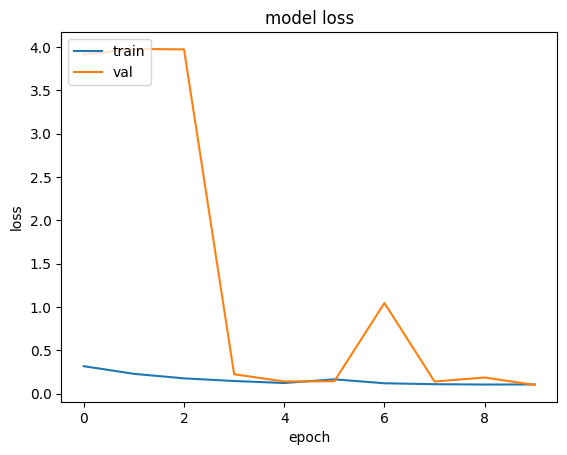

In [33]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

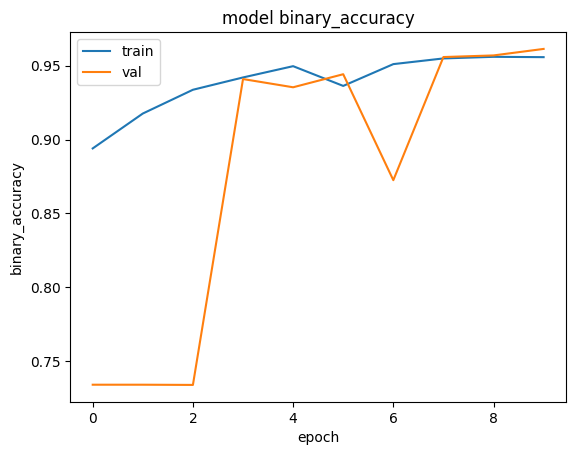

In [36]:
plt.plot(hist.history['final_binary_accuracy'])
plt.plot(hist.history['val_final_binary_accuracy'])
plt.title('model binary_accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()